### This notebook shows training process for Age & Gender classification task

I will use simple CNN model (no SoTA face recognition backbone and whatsoever, just resnet/mobilenet fine-tuned from imagenet weights)

In [ ]:
# install needed packages
!pip install torch numpy opencv-python matplotlib albumentations

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import sys
import time
from pathlib import Path
import json
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as albu
from albumentations.pytorch import ToTensor
import numpy as np
import cv2

# fix random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"python version {sys.version}, pytorch version {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name('cuda')}")

python version 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0], pytorch version 1.4.0
GPU: Tesla V100-SXM2-16GB


Straight into action: for better performing model we need regularization, I achieve that using augmentations

[Albumentations](https://github.com/albumentations-team/albumentations) is the great library

For gender & age prediction I can use most of the transforms, except rotation and cropping (because I already have cropped faces in the dataset)

Also I decided not to use elastic transforms as they consume too much cpu power

In [2]:
ROOT = Path("aligned")
labels = json.load(ROOT.joinpath("labels.json").open())

In [3]:
def show_img(image):
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.show()

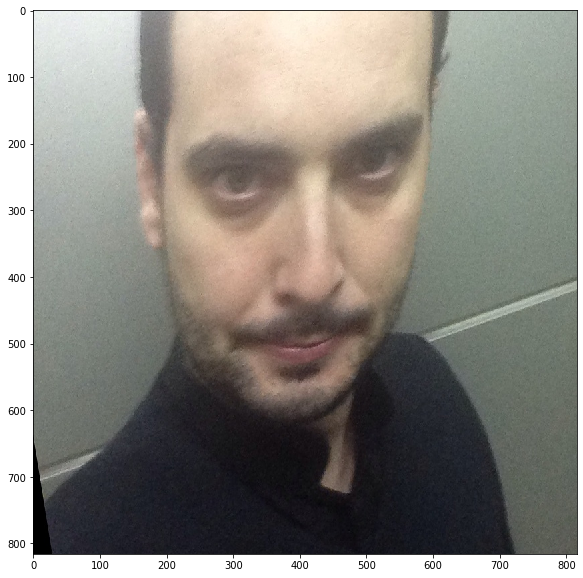

In [4]:
im = cv2.imread(str(ROOT.joinpath(list(labels)[500])))[..., ::-1]
show_img(im)

In [5]:
# define train transforms and valid transforms

# height, width
image_size = (224, 224)

augmentations = [
    albu.RandomResizedCrop(*image_size, scale=(0.6, 1)),
    albu.HorizontalFlip(),
    albu.RandomBrightnessContrast(),
    albu.OneOf([
        albu.CLAHE(),
        albu.Blur(5),
        albu.RGBShift()  
    ], p=1),
]

# for debugging purposes only
show_transforms = albu.Compose(augmentations)

train_transforms = albu.Compose([
    *augmentations,
    albu.Normalize(),
    ToTensor()
])

valid_transforms = albu.Compose([
    albu.Resize(*(np.array(image_size) * 1.25).astype(int)),
    albu.CenterCrop(*image_size),
    albu.Normalize(),
    ToTensor()
])

In [6]:
%%timeit
transformed = show_transforms(image=im)['image']

4.7 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


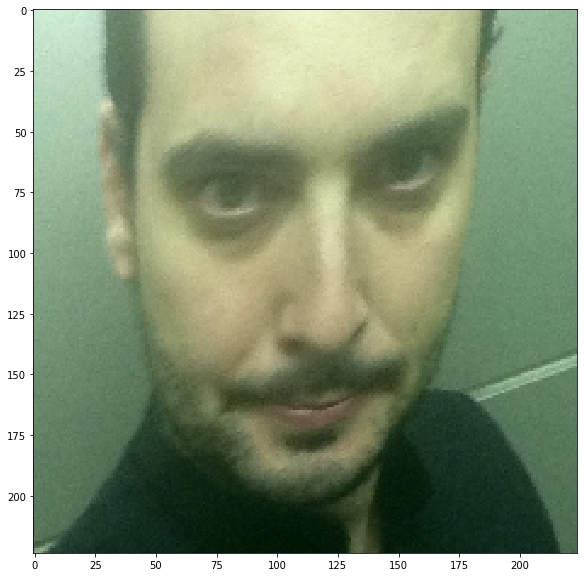

In [7]:
show_img(show_transforms(image=im)['image'])

In [8]:
class AgeGenderDataset(Dataset):
    """Very simple dataset for age&gender task"""
    def __init__(self, root, items, transform):
        self.root = root
        self.items = items
        self.transform = transform
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        filepath, meta = self.items[idx]
        img = cv2.imread(str(self.root.joinpath(filepath)))[..., ::-1]
        img = self.transform(image=img)['image']
        age_id, gender_id = torch.tensor(meta['age_id']), torch.tensor(meta['gender_id'])
        return img, (age_id, gender_id)


In [9]:
class AgeGenderModel(nn.Module):
    """
    CNN model with 2 heads and SE-block
    with multitask model learns faster
    """
    def __init__(self, encoder, encoder_channels, 
                 age_classes, gender_classes, output_channels=512):
        super().__init__()
        
        # encoder features (resnet50 in my case)
        # output should be bs x c x h x w
        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits, gender_logits
    

In [10]:
VALID_AMOUNT = 0.1
batch_size = 96

# labels for data
items = np.array(list(labels.items()))
valid_idx = np.random.randint(len(items), size=int(VALID_AMOUNT * len(items)))
train_idx = np.array([i for i in np.arange(len(items)) if not (i == valid_idx).any()])

train_loader = DataLoader(
    AgeGenderDataset(ROOT, items[train_idx], train_transforms),
    batch_size,
    shuffle=True,
    num_workers=8
)

valid_loader = DataLoader(
    AgeGenderDataset(ROOT, items[valid_idx], valid_transforms),
    batch_size,
    shuffle=False,
    num_workers=4
)

In [11]:
def accuracy(pred: torch.Tensor, gt: torch.Tensor):
    """
    accuracy metric
    
    expects pred shape bs x n_c, gt shape bs x 1
    """
    return (pred.max(1)[1] == gt).float().mean()

In [12]:
def train(model, loader, opt, 
          age_criterion, gender_criterion, metric_fn, 
          device="cuda", sched=None, epoch=1, print_every=50):
    model.train()
    t0 = time.time()
    for batch_idx, (image, (age_gt, gender_gt)) in enumerate(loader):
        data_time = time.time() - t0
        opt.zero_grad()
        t1 = time.time()
        image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
        age_logits, gender_logits = model(image)
        
        # BCE expects one-hot vector
        age_gt_onehot = torch.zeros(*age_logits.size(), device=age_logits.device)
        age_gt_onehot = age_gt_onehot.scatter_(1, age_gt.unsqueeze(-1).long(), 1)
        gender_gt = gender_gt.long()
        
        model_time = time.time() - t1
        loss_age = age_criterion(age_logits, age_gt_onehot)  # bce
        loss_gender = gender_criterion(gender_logits, gender_gt)  # softmax+ce
        loss = (loss_age + loss_gender) / 2
        loss.backward()
        opt.step()
        if sched is not None:
            sched.step()
        gender_acc = metric_fn(gender_logits, gender_gt)
        age_acc = metric_fn(age_logits, age_gt)
        
        if batch_idx % print_every == 0:
            print(f"train epoch {epoch}, {batch_idx} / {len(loader)}, loss age {loss_age.item():.3f} "
                  f"loss gender {loss_gender.item():.3f} loss: {loss.item():.3f}, "
                  f"gender acc: {gender_acc.item():.2%} age acc: {age_acc.item():.2%} "
                  f"data/model times {data_time*1000:.1f} ms, {model_time*1000:.1f} ms")
        t0 = time.time()
        

def validate(model, loader, metric_fn, device="cuda", epoch=1):
    model.eval()
    gender_acc_list = []
    age_acc_list = []
    for image, (age_gt, gender_gt) in loader:
        with torch.no_grad():
            image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
            age_logits, gender_logits = model(image)
            gender_acc_list.append(metric_fn(gender_logits, gender_gt).item())
            age_acc_list.append(metric_fn(age_logits, age_gt).item())
    gender_acc = np.mean(gender_acc_list)
    age_acc = np.mean(age_acc_list)
    print(f"val epoch {epoch}, gender acc {gender_acc:.2%}, age acc {age_acc:.2%}")
    return (gender_acc + age_acc) / 2

In [13]:
resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()

In [16]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [17]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)

train epoch 1, 0 / 169, loss age 0.618 loss gender 0.999 loss: 0.808, gender acc: 53.12% age acc: 9.38% data/model times 2922.4 ms, 39.0 ms
train epoch 1, 30 / 169, loss age 0.347 loss gender 0.461 loss: 0.404, gender acc: 77.08% age acc: 37.50% data/model times 11.4 ms, 35.3 ms
train epoch 1, 60 / 169, loss age 0.283 loss gender 0.245 loss: 0.264, gender acc: 90.62% age acc: 47.92% data/model times 11.7 ms, 32.7 ms
train epoch 1, 90 / 169, loss age 0.257 loss gender 0.199 loss: 0.228, gender acc: 92.71% age acc: 55.21% data/model times 11.4 ms, 32.6 ms
train epoch 1, 120 / 169, loss age 0.261 loss gender 0.257 loss: 0.259, gender acc: 88.54% age acc: 44.79% data/model times 386.1 ms, 77.7 ms
train epoch 1, 150 / 169, loss age 0.248 loss gender 0.262 loss: 0.255, gender acc: 91.67% age acc: 52.08% data/model times 11.6 ms, 33.0 ms
val epoch 1, gender acc 86.17%, age acc 51.59%
train epoch 2, 0 / 169, loss age 0.228 loss gender 0.233 loss: 0.231, gender acc: 91.67% age acc: 53.12% data/

gender acc 96.94%, age acc 78.79%, not bad for 10 epochs, and the model is not overfitted

### Ablation 1: try OneCycleLR scheduler

In [13]:
num_epochs = 10
lr = 3e-4

resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, div_factor=50, pct_start=0.2, 
                                                final_div_factor=1e3,
                                                steps_per_epoch=len(train_loader), epochs=num_epochs)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [14]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, sched=scheduler, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)

train epoch 1, 0 / 169, loss age 0.653 loss gender 1.157 loss: 0.905, gender acc: 35.42% age acc: 15.62% data/model times 2965.9 ms, 595.1 ms
train epoch 1, 30 / 169, loss age 0.594 loss gender 0.778 loss: 0.686, gender acc: 70.83% age acc: 18.75% data/model times 10.9 ms, 35.3 ms
train epoch 1, 60 / 169, loss age 0.483 loss gender 0.370 loss: 0.426, gender acc: 86.46% age acc: 29.17% data/model times 11.5 ms, 32.5 ms
train epoch 1, 90 / 169, loss age 0.356 loss gender 0.587 loss: 0.472, gender acc: 73.96% age acc: 39.58% data/model times 602.5 ms, 49.1 ms
train epoch 1, 120 / 169, loss age 0.293 loss gender 0.386 loss: 0.339, gender acc: 82.29% age acc: 53.12% data/model times 72.8 ms, 66.0 ms
train epoch 1, 150 / 169, loss age 0.254 loss gender 0.463 loss: 0.358, gender acc: 83.33% age acc: 55.21% data/model times 11.4 ms, 35.3 ms
val epoch 1, gender acc 67.96%, age acc 43.10%
train epoch 2, 0 / 169, loss age 0.249 loss gender 0.356 loss: 0.302, gender acc: 89.58% age acc: 53.12% dat

gender acc 96.26%, age acc 75.96%, slightly worse, so keep on using 1st option

### Ablation 2: MobileNetV3 as an encoder

In [20]:
# !pip install timm
import timm
mobilenet_v3 = timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
mobilenet_v3_encoder = nn.Sequential(*list(mobilenet_v3.children())[:-4]).cuda()

In [21]:
model = AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8, gender_classes=3).cuda()

In [22]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [23]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)

train epoch 1, 0 / 169, loss age 0.732 loss gender 1.162 loss: 0.947, gender acc: 29.17% age acc: 15.62% data/model times 2943.4 ms, 49.2 ms
train epoch 1, 30 / 169, loss age 0.372 loss gender 0.388 loss: 0.380, gender acc: 86.46% age acc: 31.25% data/model times 11.2 ms, 46.0 ms
train epoch 1, 60 / 169, loss age 0.297 loss gender 0.368 loss: 0.333, gender acc: 83.33% age acc: 44.79% data/model times 26.6 ms, 40.0 ms
train epoch 1, 90 / 169, loss age 0.287 loss gender 0.312 loss: 0.299, gender acc: 88.54% age acc: 44.79% data/model times 11.1 ms, 40.2 ms
train epoch 1, 120 / 169, loss age 0.284 loss gender 0.268 loss: 0.276, gender acc: 88.54% age acc: 47.92% data/model times 1294.0 ms, 89.2 ms
train epoch 1, 150 / 169, loss age 0.226 loss gender 0.207 loss: 0.217, gender acc: 91.67% age acc: 66.67% data/model times 10.7 ms, 37.8 ms
val epoch 1, gender acc 92.63%, age acc 57.48%
train epoch 2, 0 / 169, loss age 0.219 loss gender 0.231 loss: 0.225, gender acc: 89.58% age acc: 66.67% dat

gender acc 96.12%, age acc 82.12% for small model is great!

In [24]:
torch.save(model.state_dict(), "mobilenetv3_age.pth")